# Expriment with Sine function

In this experiment, we try to build models using Keras framework to learn and predict the sine function.
We test several parameters and check how well the networks learn and generalize.

**NOTE:** The model train methods were unified into a generalized method that could receive the hyperparameters and build distinct neural networks.

## Desktop used to run the experiment

- Computador Dell XPS-8930-A5GM
- Intel i7 8700
- RAM 16GB
- HD 2TB
- GeForce GTX 1050 Ti 4GB

## Libraries

- Keras 2.4.3 (Using GPU)
- Tensorflow 2.4.1 (Using GPU)


In [165]:
import os

import pandas as pd
import numpy as np
import math

from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## Data preparation

In this assignment, the function was modified to allow changes on the train/test sets sizes, noise scale, etc.


In [166]:
def prepare_data(noise_scale=0.1, test_size=0.15,  out_start=0, out_end=2*np.pi, ntot=100):

    
    # Proportion of train size
    train_size = 1 - test_size
    
    # Number of training examples
    ntrain = int(train_size * 100)

    # Number of test examples
    ntest = int(test_size * 100)

    #
    #  range of values from random number function generator
    #
    in_start = 0
    in_end = 1
    
    #
    # Mapping the original values of random to the disired scale
    #
    slope = (out_end - out_start) / (in_end - in_start)
    in_value = np.random.rand(ntot,1) 
    
    #
    # Final dataset
    #
    x = out_start + slope * (in_value - in_start)

    #
    # Generating noise
    #
    s=np.random.normal(0, noise_scale, size = (ntot,1))

    #
    # Generating output
    #
    y=np.sin(x)+s

    #
    # Dataset splitting
    #
    xtrain, xtest = x[:ntrain], x[ntest:]
    ytrain, ytest = y[:ntrain], y[ntest:]

    # Visualizing the train set using scatter splot
    plt.plot(xtrain.T,ytrain.T,color = 'red', marker = "o")
    plt.title("seno")
    plt.xlabel("Angulo")
    plt.ylabel("Seno")
    plt.grid()
    plt.tight_layout()
    plt.savefig("imgs/dataset_ns=%.2f_test_size=%.2f_ntot=%d.png" %(ns, test_size, ntot), dpi=200)

    return xtrain, ytrain, xtest, ytest

In [167]:
def fit_model(xtrain, ytrain, xtest, ytest, epochs, lr, ns=0.1, momentum=0.9, patience=100, batch_size=75, activation="tahn", hidden_layer_size=10):
    """
    Method to train Networks 
    """
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
    # define model
    model = Sequential([Dense(hidden_layer_size, activation=activation, input_dim=1),
                        Dense(1, activation='linear')
                       ])
                       
    # compile model
    opt = SGD(lr, momentum=momentum)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    # fit model
    history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=epochs,  batch_size=batch_size, verbose=0, callbacks=[early_stop])

    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('learning rate='+str(lr), pad=-80)

    output_path = "imgs/model_loss_ns=%.2f_epochs=%d_lr=%.2f_mom=%.2f_activation=%s_pati=%d.png"  %(ns, epochs, lr, momentum, activation, patience)
    plt.tight_layout()
    plt.savefig(output_path, dpi=200)
    
    return model

# Report for the Exercise

In this report, we try different setups of noise scale (ns), activation functions (af), learning rates (lr), patience


In [168]:
#
# Creating hyperparameters options
#

noise_scale_list = [0.05]#, 0.1, 0.2]
act_func_list = ["relu"]#, "tanh", "sigmoid"]
lr_list = [0.01]#, 0.1]
patience_list = [100]#, 300]
hidden_layer_list = [10]#, 50, 100]

epochs = 5000

# Min and max value of sin function to learn
min_value = 0
max_value = 2*np.pi

train_test_ratio = 0.5

num_examples = 100

=== Training network (ns: 0.05, act_funct: relu; lr: 0.01; patience:100, hidden_layer_size:10) ===


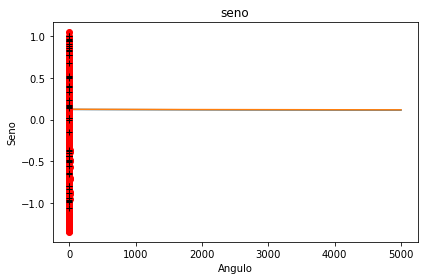

In [169]:

data = []
for ns in noise_scale_list:
    for act_funct in act_func_list:
        for lr in lr_list:
            for patience in patience_list:
                for hidden_layer_size in hidden_layer_list:
                    print("=== Training network (ns: %.2f, act_funct: %s; lr: %.2f; patience:%d, hidden_layer_size:%d) ===" % (ns, act_funct, lr, patience, hidden_layer_size))

                    #
                    # Preparing dataset
                    #
                    xtrain, ytrain, xtest, ytest = prepare_data(ntot=num_examples, noise_scale=ns, out_start=0, out_end=max_value, test_size=0.5)

                    scaler = preprocessing.MinMaxScaler()
                    # fit using the train set
                    scaler.fit(xtrain)
                    # transform the test test
                    xtrainN = scaler.transform(xtrain)
                    xtestN = scaler.transform(xtest) 

                    X = np.linspace(0.0 , 2.0 * np.pi, num_examples).reshape(-1, 1)
                    XN = scaler.transform(X)

                    #
                    # Fitting model
                    #
                    tf.keras.backend.clear_session()
                    
                    model = fit_model(xtrainN, ytrain, xtestN, ytest, epochs=epochs, lr=lr, activation=act_funct, patience=patience, hidden_layer_size=hidden_layer_size)

                    #
                    # Making predictions
                    #
                    Y = model.predict(XN)
                    plt.plot(XN,Y,color = 'red', marker = "o")
                    plt.plot(xtestN.T,ytest.T,color = 'black', marker= "+")
                    plt.title("seno")
                    plt.xlabel("Angulo")
                    plt.ylabel("Seno")
                    plt.grid()

                    y_pred = model.predict(xtestN)

                    mse = mean_squared_error(ytest, y_pred)

                    output_path = "imgs/prediction_ns=%.2f_activation=%s_lr=%.2f_pati=%d_hidden=%d.png"  % (ns, act_funct, lr, patience, hidden_layer_size)
                    plt.tight_layout()
                    plt.savefig(output_path, dpi=200)


                    data.append([ns, act_funct, lr, patience, hidden_layer_size, mse])

df = pd.DataFrame(data, columns=[    "Ns",    "Activation",    "Lr", "patience","hidden_layer", "mse"])
df.to_excel("results.xlsx", index=False)